# Reto SAS: Fundraising Scenario Segunda Parte

Edgar Castillo Ramírez A00827826

En esta segunda parte lo que se realiza es que con ayuda de un modelo de Clasificación se predice la probabilidad de si una persona donará o no. El modelo ganador fue Decision Tree Model. También aquí se calcula el Uplift, que es Donación esperada = Probabilidad de donar * Cantidad dada.

## Primera parte: Preparación de datos

**0- Connect to your Google Drive folder**

In [ ]:
my_folder = "/content/drive/MyDrive/2022/AI/A00827826_Fundraising"

from google.colab import drive
drive.mount('/content/drive')

# Change the following code to set your Drive folder
import os
os.chdir(my_folder)
!pwd

Mounted at /content/drive
/content/drive/MyDrive/2022/AI/A00827826_Fundraising


**1- Make sure that your Python version is 3.3 or higher as well as your Java version is 1.8.0_162 or higher**

In [ ]:
!echo "Python is at" $(which python)
!python --version

Python is at /usr/local/bin/python
Python 3.8.15


In [ ]:
!echo "Java is at" $(which java)
!/usr/bin/java -version

Java is at /usr/bin/java
openjdk version "11.0.17" 2022-10-18
OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)


**2- Install SASPy**

In [ ]:
!pip install saspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 4.1 MB/s 
  Created wheel for saspy: filename=saspy-4.4.1-py3-none-any.whl size=9937304 sha256=473915182d086537d566fd28b4d86ce49ebbeb629bc7d1464e2b9a4d38ed11e7
  Stored in directory: /root/.cache/pip/wheels/0a/f6/ab/f7173c8a824856c66f6fd50194bb8fd3ef93fb4f1824be8d0c
Successfully built saspy


**3- Create the configuration file "sascfg_personal.py"**
Please, check that your Home Region is correct, you can check it at [ODA-SAS](https://welcome.oda.sas.com/home)

In [ ]:
%%writefile sascfg_personal.py
SAS_config_names=['oda']
oda = {'java' : '/usr/bin/java',
#US Home Region 1
#'iomhost' : ['odaws01-usw2.oda.sas.com','odaws02-usw2.oda.sas.com','odaws03-usw2.oda.sas.com','odaws04-usw2.oda.sas.com'],
#US Home Region 2
'iomhost' : ['odaws01-usw2-2.oda.sas.com','odaws02-usw2-2.oda.sas.com'],
#European Home Region 1
#'iomhost' : ['odaws01-euw1.oda.sas.com','odaws02-euw1.oda.sas.com'],
#Asia Pacific Home Region 1
#'iomhost' : ['odaws01-apse1.oda.sas.com','odaws02-apse1.oda.sas.com'],
#Asia Pacific Home Region 2
#'iomhost' : ['odaws01-apse1-2.oda.sas.com','odaws02-apse1-2.oda.sas.com'],
'iomport' : 8591,
'authkey' : 'oda',
'encoding' : 'utf-8'
}

Overwriting sascfg_personal.py


**4- Create your .authinfo**

In [ ]:
#%%writefile .authinfo
#oda user A00827826@tec.mx password 0683D0ctorJAY$

Writing .authinfo


Copy this file to home

In [ ]:
!cp .authinfo ~/.authinfo

**5- Establish Connection (Need to do this step each time you use SASPy)**

In [ ]:
import saspy
sas_session = saspy.SASsession(cfgfile=os.path.join(
    my_folder,"sascfg_personal.py"))
sas_session

Using SAS Config named: oda
SAS Connection established. Subprocess id is 372



Access Method         = IOM
SAS Config name       = oda
SAS Config file       = /content/drive/MyDrive/2022/AI/A00827826_Fundraising/sascfg_personal.py
WORK Path             = /saswork/SAS_workB18E0001CE95_odaws01-usw2-2.oda.sas.com/SAS_work72C80001CE95_odaws01-usw2-2.oda.sas.com/
SAS Version           = 9.04.01M6P11072018
SASPy Version         = 4.4.1
Teach me SAS          = False
Batch                 = False
Results               = Pandas
SAS Session Encoding  = utf-8
Python Encoding value = utf-8
SAS process Pid value = 118421


**SAS Dataset Connection**

In [ ]:
ps = sas_session.submit("""
    libname cortex '~/my_shared_file_links/u39842936/Cortex Data Sets';
    """)
print(ps["LOG"])


5                                                          The SAS System                      Friday, December  2, 2022 05:04:00 AM

24         ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=HTMLBlue;
24       ! ods graphics on / outputfmt=png;
25         
26         
27             libname cortex '~/my_shared_file_links/u39842936/Cortex Data Sets';
28         
29         
30         
31         ods html5 (id=saspy_internal) close;ods listing;
32         

6                                                          The SAS System                      Friday, December  2, 2022 05:04:00 AM

33         


**Dataset conversion into Pandas**

In [ ]:
import pandas as pd

data1 = sas_session.sasdata2dataframe(
table='hist',
libref='cortex'
)

data2 = sas_session.sasdata2dataframe(
table='target_rd2',
libref='cortex'
)

**Merging the data**

In [ ]:
data_merge = pd.merge(data1, data2, on=["ID"],how="right")
data_merge.sample(2)

,ID,LastName,FirstName,Woman,Age,Salary,Education,City,SeniorList,NbActivities,...,Frequency,Seniority,TotalGift,MinGift,MaxGift,GaveLastYear,AmtLastYear,Contact,GaveThisYear,AmtThisYear
769873,2769874.0,JONES,JENNY,1.0,22.0,18200.0,High School,Rural,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
363423,2363424.0,WILSON,PAM,1.0,34.0,113600.0,University / College,Rural,4.0,1.0,...,1.0,1.0,500.0,500.0,500.0,0.0,0.0,0.0,1.0,40.0


**Missing values**

In [ ]:
data_merge.describe()

,ID,Woman,Age,Salary,SeniorList,NbActivities,Referrals,Recency,Frequency,Seniority,TotalGift,MinGift,MaxGift,GaveLastYear,AmtLastYear,Contact,GaveThisYear,AmtThisYear
count,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,336334.000000,336334.000000,336334.000000,336334.000000,336334.000000,336334.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000,1000000.000000
mean,2.500000e+06,0.516936,46.366170,65531.654000,4.582967,0.561413,0.560556,3.039636,1.666882,4.474148,104.454055,43.130251,85.897932,0.122101,7.673015,0.1,0.149457,9.409665
std,2.886753e+05,0.499713,18.945324,61051.122343,3.325844,0.996803,1.054027,2.120722,1.052090,2.588119,303.760477,150.249476,283.581066,0.327403,82.224854,0.3,0.356539,90.917731
min,2.000001e+06,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,2.250001e+06,0.000000,30.000000,20700.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.000000,20.000000,15.000000,20.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,2.500000e+06,1.000000,46.000000,44000.000000,4.000000,0.000000,0.000000,2.000000,1.000000,4.000000,40.000000,20.000000,30.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2.750000e+06,1.000000,61.000000,91200.000000,7.000000,1.000000,1.000000,4.000000,2.000000,6.000000,90.000000,30.000000,75.000000,0.000000,0.000000,0.0,0.000000,0.000000
max,3.000000e+06,1.000000,90.000000,250000.000000,10.000000,10.000000,16.000000,10.000000,10.000000,10.000000,15150.000000,10000.000000,10000.000000,1.000000,10000.000000,1.0,1.000000,10000.000000


In [ ]:
#Podemos ver que Recency, Frequency, Seniority, TotalGift, MinGift y MaxGift son variables que tienen una buena cantidad de NaN
data_merge.isnull().sum()

ID                   0
LastName            23
FirstName            4
Woman                0
Age                  0
Salary               0
Education            0
City                 0
SeniorList           0
NbActivities         0
Referrals            0
Recency         663666
Frequency       663666
Seniority       663666
TotalGift       663666
MinGift         663666
MaxGift         663666
GaveLastYear         0
AmtLastYear          0
Contact              0
GaveThisYear         0
AmtThisYear          0
dtype: int64

In [ ]:
#Esto no se usa
data_merge[['MinGift']] = data_merge[['MinGift']].fillna(value=data_merge['MinGift'].mean())  
data_merge[['MaxGift']] = data_merge[['MaxGift']].fillna(value=data_merge['MaxGift'].mean())  

data_merge.sample(5)

,ID,LastName,FirstName,Woman,Age,Salary,Education,City,SeniorList,NbActivities,...,Frequency,Seniority,TotalGift,MinGift,MaxGift,GaveLastYear,AmtLastYear,Contact,GaveThisYear,AmtThisYear
869435,2869436.0,WAH,JOSEPH,0.0,50.0,233300.0,High School,City,7.0,0.0,...,NaN,NaN,NaN,43.130251,85.897932,0.0,0.0,0.0,0.0,0.0
708983,2708984.0,ENGLISH,JOSEPH,0.0,56.0,74800.0,High School,City,4.0,1.0,...,NaN,NaN,NaN,43.130251,85.897932,0.0,0.0,0.0,0.0,0.0
529513,2529514.0,NEGRI,HOLLY,1.0,72.0,33900.0,High School,Rural,6.0,1.0,...,1.0,6.0,75.0,75.000000,75.000000,0.0,0.0,0.0,0.0,0.0
177181,2177182.0,MCCARLEY,GINGER,1.0,27.0,10000.0,University / College,Suburban,8.0,0.0,...,NaN,NaN,NaN,43.130251,85.897932,0.0,0.0,0.0,0.0,0.0
627936,2627937.0,MOORE,DEB,1.0,90.0,16100.0,University / College,City,3.0,0.0,...,1.0,2.0,25.0,25.000000,25.000000,1.0,20.0,0.0,0.0,0.0


**Data Partition**

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data_merge, test_size=0.35, random_state=42)
train.sample(5)

,ID,LastName,FirstName,Woman,Age,Salary,Education,City,SeniorList,NbActivities,...,Frequency,Seniority,TotalGift,MinGift,MaxGift,GaveLastYear,AmtLastYear,Contact,GaveThisYear,AmtThisYear
278985,2278986.0,BARRETT,KENNETH,0.0,61.0,2100.0,University / College,Suburban,0.0,0.0,...,NaN,NaN,NaN,43.130251,85.897932,0.0,0.0,0.0,0.0,0.0
363340,2363341.0,NOLASCO,PAUL,0.0,64.0,119600.0,High School,Suburban,0.0,0.0,...,NaN,NaN,NaN,43.130251,85.897932,0.0,0.0,0.0,0.0,0.0
868763,2868764.0,BERNARDINI,LINDA,1.0,51.0,13400.0,University / College,Suburban,4.0,1.0,...,NaN,NaN,NaN,43.130251,85.897932,1.0,40.0,0.0,0.0,0.0
851452,2851453.0,ESTES,MICHAEL,0.0,26.0,52300.0,University / College,City,0.0,0.0,...,NaN,NaN,NaN,43.130251,85.897932,0.0,0.0,0.0,0.0,0.0
248993,2248994.0,TRACY,JERALD,0.0,47.0,48200.0,University / College,Suburban,3.0,0.0,...,NaN,NaN,NaN,43.130251,85.897932,0.0,0.0,0.0,0.0,0.0


## Segunda parte: Modelos

**Logistic Regression Model**

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train = train[['Age', 'Salary', 'GaveLastYear','Contact', 'Woman', 'NbActivities', 'Referrals']] 
Y_train = train['GaveThisYear']
X_valid = validation[['Age', 'Salary', 'GaveLastYear','Contact', 'Woman', 'NbActivities', 'Referrals']] 
Y_valid = validation['GaveThisYear']

regr = LogisticRegression()
regr.fit(X_train,Y_train)
regr_predict=regr.predict(X_valid)

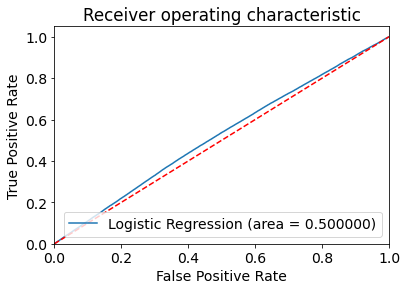

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

logit_roc_auc = roc_auc_score(Y_valid, regr.predict(X_valid))
fpr, tpr, thresholds = roc_curve(Y_valid, regr.predict_proba(X_valid)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.6f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

**Decision Tree Model**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X_train = train[['Age', 'Salary', 'GaveLastYear','Contact', 'Woman', 'NbActivities', 'Referrals']] 
Y_train = train['GaveThisYear']
X_valid = validation[['Age', 'Salary', 'GaveLastYear','Contact', 'Woman', 'NbActivities', 'Referrals']] 
Y_valid = validation['GaveThisYear']

DT_model = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train,Y_train)
DT_predict_proba = DT_model.predict_proba(X_valid) 
DT_predict = DT_model.predict(X_valid)

DT_probs = DT_model.predict_proba(X_valid)[:, 1]
print(DT_probs)

[0.1077307  0.07874381 0.1077307  ... 0.1077307  0.11958263 0.19487427]


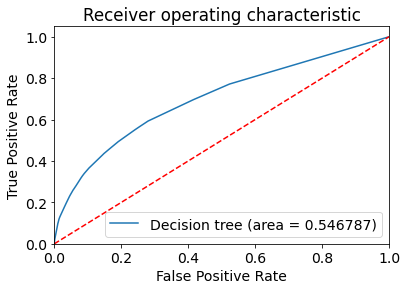

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

DT_roc_auc = roc_auc_score(Y_valid, DT_model.predict(X_valid))
fpr, tpr, thresholds = roc_curve(Y_valid, DT_model.predict_proba(X_valid)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision tree (area = %0.6f)' % DT_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('DT_ROC')
plt.show()

**Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train = train[['Age', 'Salary', 'GaveLastYear','Contact', 'Woman', 'NbActivities', 'Referrals']] 
Y_train = train['GaveThisYear']
X_valid = validation[['Age', 'Salary', 'GaveLastYear','Contact', 'Woman', 'NbActivities', 'Referrals']] 
Y_valid = validation['GaveThisYear']

RFR_Class=RandomForestClassifier(n_estimators= 50).fit(X_train,Y_train)

y_pred=RFR_Class.predict(X_valid)

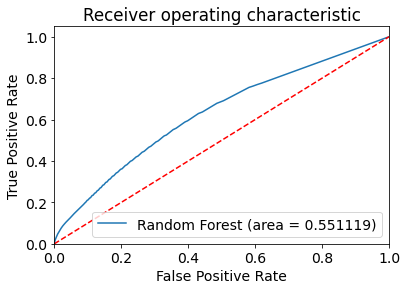

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

RF_roc_auc = roc_auc_score(Y_valid, RFR_Class.predict(X_valid))
fpr, tpr, thresholds = roc_curve(Y_valid, RFR_Class.predict_proba(X_valid)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.6f)' % RF_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

XGBoost Model

In [ ]:
import xgboost as xgb

X_train = train[['Age', 'Salary', 'GaveLastYear','Contact', 'Woman', 'NbActivities', 'Referrals']] 
Y_train = train['GaveThisYear']
X_valid = validation[['Age', 'Salary', 'GaveLastYear','Contact', 'Woman', 'NbActivities', 'Referrals']] 
Y_valid = validation['GaveThisYear']

XGB_Class=xgb.XGBClassifier(n_estimators=100).fit(X_train,Y_train)

y_pred=XGB_Class.predict(X_valid)

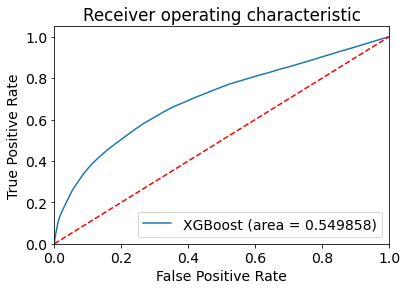

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

XGB_roc_auc = roc_auc_score(Y_valid, XGB_Class.predict(X_valid))
fpr, tpr, thresholds = roc_curve(Y_valid, XGB_Class.predict_proba(X_valid)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.6f)' % XGB_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()

## Tercera parte: Scoring y Creación del archivo CSV

**Prepare the data**

In [ ]:
data3 = sas_session.sasdata2dataframe(
table='score',
libref='cortex'
)
data4 = sas_session.sasdata2dataframe(
table='score_rd2_contact',
libref='cortex'
)
data5 = sas_session.sasdata2dataframe(
table='SCORE_RD2_NOCONTACT',
libref='cortex'
)

NameError: ignored

**Scoring the data with the best model found**

### Predict 'probability of giving' for members who were contacted

In [ ]:
scoring_data_contact = pd.merge(data3, data4, on=["ID"],how="right")

X = scoring_data_contact[['Age', 'Salary', 'GaveLastYear','Contact', 'Woman', 'NbActivities', 'Referrals']] 
DT_predict_contact=DT_model.predict_proba(X)[:,1]
scoring_data_contact['Prediction_prob'] = DT_predict_contact

scoring_data_contact= scoring_data_contact[['ID','Prediction_prob']]
scoring_data_contact = scoring_data_contact.rename({'Prediction_prob': 'ProbContact'}, axis=1) 
scoring_data_contact.head()

,ID,ProbContact
0,2000001.0,0.284662
1,2000002.0,0.587196
2,2000003.0,0.587196
3,2000004.0,0.373302
4,2000005.0,0.587196


### Predict 'probability of giving' for members who were not contacted

In [ ]:
scoring_data_nocontact = pd.merge(data3, data5, on=["ID"],how="right")

X = scoring_data_nocontact[['Age', 'Salary', 'GaveLastYear','Contact', 'Woman', 'NbActivities', 'Referrals']] 
DT_predict_nocontact=DT_model.predict_proba(X)[:,1]
scoring_data_nocontact['Prediction_prob'] = DT_predict_nocontact

scoring_data_nocontact= scoring_data_nocontact[['ID','Prediction_prob']]
scoring_data_nocontact = scoring_data_nocontact.rename({'Prediction_prob': 'ProbNoContact'}, axis=1) 
scoring_data_nocontact.head()

,ID,ProbNoContact
0,2000001.0,0.078744
1,2000002.0,0.119583
2,2000003.0,0.078744
3,2000004.0,0.078744
4,2000005.0,0.078744


In [ ]:
result_Prob = pd.merge(scoring_data_contact, scoring_data_nocontact, on=["ID"],how="right")
result_Prob.sort_values(by=['ID'], inplace=True)
result_Prob.sample(10)

,ID,ProbContact,ProbNoContact
704074,2704075.0,0.613487,0.170372
606920,2606921.0,0.153214,0.107731
905260,2905261.0,0.587196,0.078744
781411,2781412.0,0.587196,0.078744
978535,2978536.0,0.373302,0.107731
174275,2174276.0,0.587196,0.119583
203213,2203214.0,0.365447,0.107731
640849,2640850.0,0.337805,0.119583
214759,2214760.0,0.373302,0.213873
925294,2925295.0,0.734694,0.213873


### **CSV Files**

In [ ]:
result_Prob.to_csv('Round2_Output_prob.csv', index=False)

In [ ]:
import pandas as pd

NB = 187000

probabilities = pd.read_csv("Round2_Output_prob.csv")
amounts = pd.read_csv("Round2_Output_amt.csv")

def Calc_Uplift(raw_data):
    return ((raw_data['AmtContact']*raw_data['ProbContact']) - (raw_data['AmtNoContact']*raw_data['ProbNoContact']))

raw_submission = pd.merge(probabilities, amounts, on=["ID"], how="right")
raw_submission["Uplift"] = raw_submission.apply(lambda row: Calc_Uplift(row), axis=1)

raw_submission.sort_values(by=['Uplift'], ascending=False, inplace=True)

In [ ]:
# Exportar a CSV

submission = raw_submission.head(NB)

submission.to_csv('Round2 Output final.csv', index=False)


In [ ]:
!head Round2\ Output\ final.csv

ID,ProbContact,ProbNoContact,AmtContact,AmtNoContact,Uplift
2407787.0,0.7884322678843226,0.170371720116618,555.9105330423431,102.7837560371362,420.7863569912635
2863239.0,0.7884322678843226,0.170371720116618,555.8126389086867,102.68586190347986,420.72585248939265
2171880.0,0.7884322678843226,0.170371720116618,555.8126389086867,102.68586190347986,420.72585248939265
2298463.0,0.7884322678843226,0.170371720116618,555.7399950274746,102.6132180222677,420.6809541723787
2608960.0,0.7884322678843226,0.170371720116618,555.5696419630905,102.44286495788354,420.57566566409156
2738499.0,0.7884322678843226,0.170371720116618,555.5696419630905,102.44286495788354,420.57566566409156
2369504.0,0.7884322678843226,0.170371720116618,554.9958293790332,101.86905237382628,420.22101474407316
2682599.0,0.7884322678843226,0.2596477340193944,566.7101125192981,104.08460535536122,419.78720731974744
2356412.0,0.7884322678843226,0.2596477340193944,566.686983187464,104.06147602352704,419.7749768867949
